
🔗 GOOGLE COLAB DETECTED

📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully!
✓ Working directory: /content/drive/MyDrive/Olive-Foods-ML/

🍽️  OLIVE FOODS - ML MODEL TRAINING

Health-Based Food Recommendation System
Training machine learning model for personalized food recommendations

📊 LOADING DATASET
✓ Dataset loaded successfully!
  - Path: /content/drive/MyDrive/Olive-Foods-ML/food_health_dataset.csv
  - Shape: (132, 12)
  - Food items: 132

📋 First few rows:
   food_id              food_name         category  calories  protein  \
0        1  Grilled Chicken Salad  Salads & Greens       252       29   
1        2           Caesar Salad  Salads & Greens       224       20   
2        3            Greek Salad  Salads & Greens       307       15   
3        4             Kale Salad  Salads & Greens       171       21   
4        5          Spinac

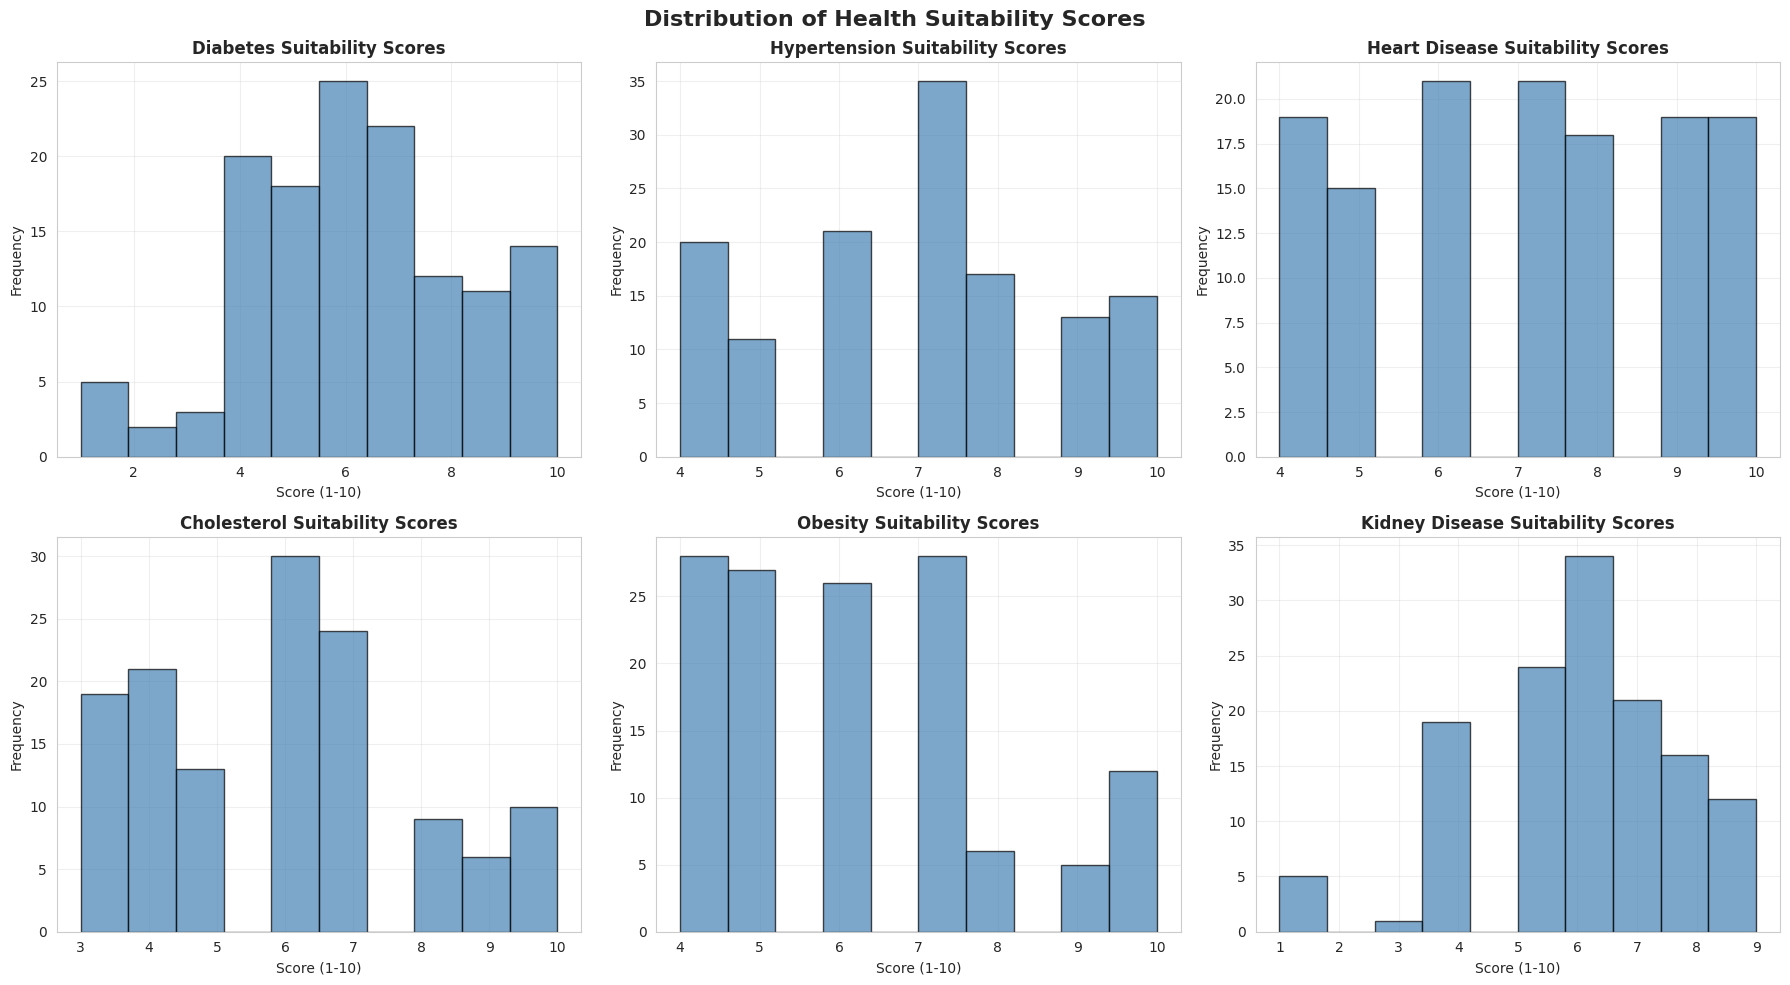

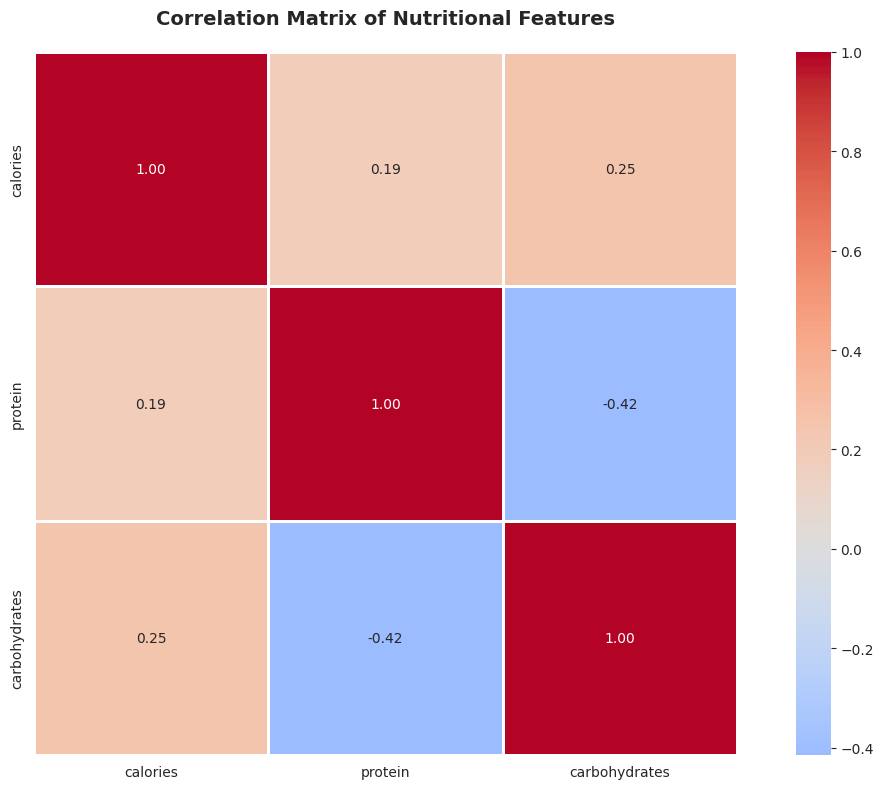

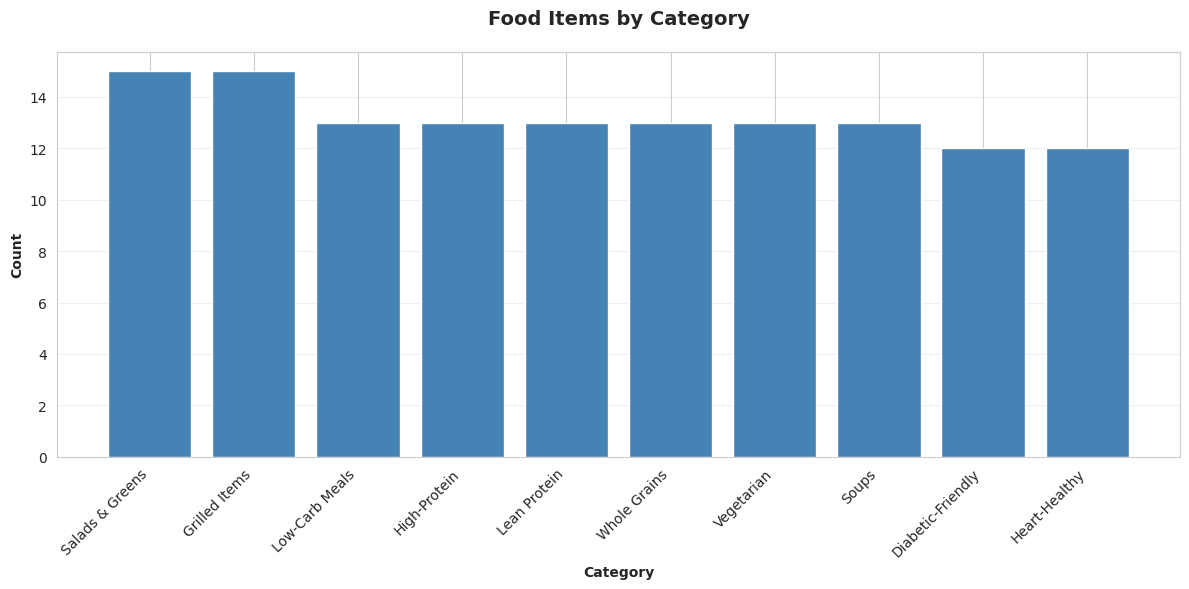

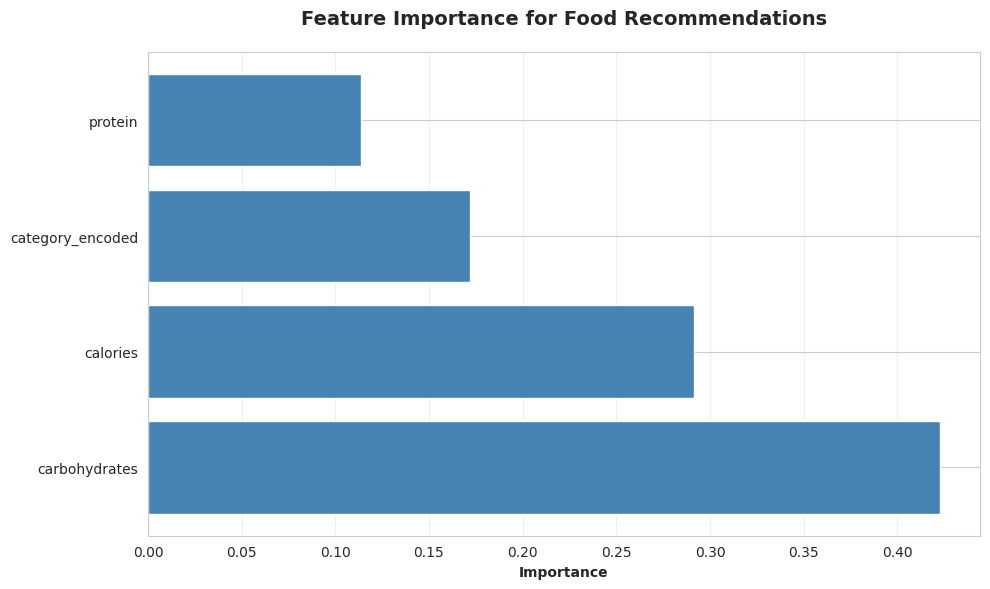

In [4]:
"""
OLIVE FOODS - ML Model Training Script
Health-Based Food Recommendation System

This script trains a machine learning model to predict food suitability
based on nutritional information and health conditions.

Usage:
    python train_model.py

The script will:
1. Load the dataset from food_health_dataset.csv
2. Perform data preprocessing and feature engineering
3. Train multiple ML models
4. Evaluate model performance
5. Save the best model and preprocessing objects

Author: Olive Foods Team
Date: 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import joblib
import warnings
import os
import sys

warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================
# GOOGLE COLAB SETUP
# ============================================

def setup_colab_environment():
    """
    Detect if running in Google Colab and mount Google Drive
    Returns: base_path for files
    """
    try:
        import google.colab
        IN_COLAB = True
        print("\n" + "="*70)
        print("🔗 GOOGLE COLAB DETECTED")
        print("="*70)

        # Mount Google Drive
        from google.colab import drive
        print("\n📁 Mounting Google Drive...")
        drive.mount('/content/drive')
        print("✓ Google Drive mounted successfully!")

        # Set base path to Google Drive
        base_path = '/content/drive/MyDrive/Olive-Foods-ML/'

        # Create directory if it doesn't exist
        os.makedirs(base_path, exist_ok=True)
        print(f"✓ Working directory: {base_path}")

        return base_path, IN_COLAB

    except ImportError:
        # Not in Colab, use local paths
        print("\n💻 Running locally")
        return '', False

# Initialize environment
BASE_PATH, IN_COLAB = setup_colab_environment()

class FoodRecommendationModel:
    """Food Recommendation ML Model Trainer"""

    def __init__(self, dataset_path='food_health_dataset.csv'):
        """Initialize the model trainer"""
        self.dataset_path = dataset_path
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = None
        self.model = None
        self.feature_cols = None
        self.target_cols = None

    def load_data(self):
        """Load dataset from CSV file"""
        print("\n" + "="*70)
        print("📊 LOADING DATASET")
        print("="*70)

        # Construct full path with BASE_PATH
        full_dataset_path = os.path.join(BASE_PATH, self.dataset_path) if BASE_PATH else self.dataset_path

        try:
            self.df = pd.read_csv(full_dataset_path)
            print(f"✓ Dataset loaded successfully!")
            print(f"  - Path: {full_dataset_path}")
            print(f"  - Shape: {self.df.shape}")
            print(f"  - Food items: {len(self.df)}")
            print(f"\n📋 First few rows:")
            print(self.df.head())
            return True
        except FileNotFoundError:
            print(f"✗ Error: Dataset file not found!")
            print(f"  Looking for: {full_dataset_path}")

            if IN_COLAB:
                print(f"\n💡 Tip: Upload dataset to Google Drive at:")
                print(f"  {BASE_PATH}")
                print(f"\n  Or run generate_dataset.py first to create it.")
            else:
                print(f"  Please make sure '{self.dataset_path}' exists in the current directory.")
            return False
        except Exception as e:
            print(f"✗ Error loading dataset: {str(e)}")
            return False

    def explore_data(self):
        """Perform exploratory data analysis"""
        print("\n" + "="*70)
        print("🔍 EXPLORATORY DATA ANALYSIS")
        print("="*70)

        print("\n📊 Dataset Info:")
        print("-" * 70)
        print(self.df.info())

        print("\n📈 Statistical Summary:")
        print("-" * 70)
        print(self.df.describe())

        # Check for missing values
        missing = self.df.isnull().sum()
        if missing.any():
            print("\n⚠️  Missing Values:")
            print(missing[missing > 0])
        else:
            print("\n✓ No missing values found!")

        # Category distribution
        print("\n📊 Category Distribution:")
        print(self.df['category'].value_counts())

        # Visualizations
        self._create_visualizations()

    def _create_visualizations(self):
        """Create data visualizations"""
        print("\n📊 Creating visualizations...")

        # 1. Distribution of health scores
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Distribution of Health Suitability Scores', fontsize=16, fontweight='bold')

        score_cols = ['diabetes_score', 'hypertension_score', 'heart_disease_score',
                     'cholesterol_score', 'obesity_score', 'kidney_score']
        titles = ['Diabetes', 'Hypertension', 'Heart Disease',
                 'Cholesterol', 'Obesity', 'Kidney Disease']

        for idx, (col, title) in enumerate(zip(score_cols, titles)):
            row = idx // 3
            col_idx = idx % 3
            axes[row, col_idx].hist(self.df[col], bins=10, edgecolor='black',
                                   alpha=0.7, color='steelblue')
            axes[row, col_idx].set_title(f'{title} Suitability Scores', fontweight='bold')
            axes[row, col_idx].set_xlabel('Score (1-10)')
            axes[row, col_idx].set_ylabel('Frequency')
            axes[row, col_idx].grid(alpha=0.3)

        plt.tight_layout()
        viz_path = os.path.join(BASE_PATH, 'health_scores_distribution.png') if BASE_PATH else 'health_scores_distribution.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {viz_path}")

        # 2. Correlation heatmap
        plt.figure(figsize=(12, 8))
        correlation_cols = ['calories', 'protein', 'carbohydrates']
        correlation_matrix = self.df[correlation_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, square=True, linewidths=1)
        plt.title('Correlation Matrix of Nutritional Features',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        viz_path = os.path.join(BASE_PATH, 'correlation_matrix.png') if BASE_PATH else 'correlation_matrix.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {viz_path}")

        # 3. Category distribution
        plt.figure(figsize=(12, 6))
        category_counts = self.df['category'].value_counts()
        plt.bar(range(len(category_counts)), category_counts.values, color='steelblue')
        plt.xlabel('Category', fontweight='bold')
        plt.ylabel('Count', fontweight='bold')
        plt.title('Food Items by Category', fontsize=14, fontweight='bold', pad=20)
        plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        viz_path = os.path.join(BASE_PATH, 'category_distribution.png') if BASE_PATH else 'category_distribution.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {viz_path}")

    def preprocess_data(self):
        """Preprocess and prepare data for training"""
        print("\n" + "="*70)
        print("⚙️  DATA PREPROCESSING")
        print("="*70)

        # Encode categorical variable
        label_encoder = LabelEncoder()
        self.df['category_encoded'] = label_encoder.fit_transform(self.df['category'])
        print("\n✓ Category encoding completed")
        print(f"  - Categories: {list(label_encoder.classes_)}")

        # Create binary suitability labels (score >= 7 is suitable)
        threshold = 7
        self.df['diabetes_suitable'] = (self.df['diabetes_score'] >= threshold).astype(int)
        self.df['hypertension_suitable'] = (self.df['hypertension_score'] >= threshold).astype(int)
        self.df['heart_disease_suitable'] = (self.df['heart_disease_score'] >= threshold).astype(int)
        self.df['cholesterol_suitable'] = (self.df['cholesterol_score'] >= threshold).astype(int)
        self.df['obesity_suitable'] = (self.df['obesity_score'] >= threshold).astype(int)
        self.df['kidney_suitable'] = (self.df['kidney_score'] >= threshold).astype(int)

        print(f"\n✓ Binary labels created (threshold: {threshold})")

        # Define feature and target columns
        self.feature_cols = ['calories', 'protein', 'carbohydrates', 'category_encoded']
        self.target_cols = ['diabetes_suitable', 'hypertension_suitable',
                           'heart_disease_suitable', 'cholesterol_suitable',
                           'obesity_suitable', 'kidney_suitable']

        # Prepare X and y
        X = self.df[self.feature_cols]
        y = self.df[self.target_cols]

        print(f"\n✓ Features prepared:")
        print(f"  - Feature shape: {X.shape}")
        print(f"  - Features: {self.feature_cols}")
        print(f"\n✓ Targets prepared:")
        print(f"  - Target shape: {y.shape}")
        print(f"  - Targets: {self.target_cols}")

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        print(f"\n✓ Data split completed:")
        print(f"  - Training set: {self.X_train.shape[0]} samples")
        print(f"  - Testing set: {self.X_test.shape[0]} samples")

        # Scale features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"\n✓ Feature scaling completed")

    def train_models(self):
        """Train multiple ML models and select the best one"""
        print("\n" + "="*70)
        print("🤖 MODEL TRAINING")
        print("="*70)

        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,
                                                   max_depth=10, min_samples_split=5),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42,
                                                           max_depth=5, learning_rate=0.1),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8)
        }

        results = {}

        for name, base_model in models.items():
            print(f"\n🔄 Training {name}...")
            model = MultiOutputClassifier(base_model)
            model.fit(self.X_train_scaled, self.y_train)

            # Predictions
            y_pred = model.predict(self.X_test_scaled)
            accuracy = accuracy_score(self.y_test, y_pred)

            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred
            }

            print(f"  ✓ {name} accuracy: {accuracy:.4f}")

        # Select best model
        best_model_name = max(results, key=lambda x: results[x]['accuracy'])
        self.model = results[best_model_name]['model']

        print(f"\n🏆 Best Model: {best_model_name}")
        print(f"  - Accuracy: {results[best_model_name]['accuracy']:.4f}")

        return results, best_model_name

    def evaluate_model(self):
        """Evaluate model performance"""
        print("\n" + "="*70)
        print("📊 MODEL EVALUATION")
        print("="*70)

        # Predictions
        y_pred = self.model.predict(self.X_test_scaled)
        overall_accuracy = accuracy_score(self.y_test, y_pred)

        print(f"\n🎯 Overall Accuracy: {overall_accuracy:.4f}")
        print("\n" + "-"*70)
        print("Accuracy per Health Condition:")
        print("-"*70)

        # Per-condition accuracy
        for idx, condition in enumerate(self.target_cols):
            acc = accuracy_score(self.y_test.iloc[:, idx], y_pred[:, idx])
            print(f"  {condition:30s}: {acc:.4f}")

        # Detailed classification report
        print("\n" + "-"*70)
        print("Detailed Classification Reports:")
        print("-"*70)

        for idx, condition in enumerate(self.target_cols):
            print(f"\n{condition}:")
            print(classification_report(self.y_test.iloc[:, idx], y_pred[:, idx],
                                      target_names=['Not Suitable', 'Suitable']))

        # Feature importance (for Random Forest)
        if hasattr(self.model.estimators_[0], 'feature_importances_'):
            self._plot_feature_importance()

    def _plot_feature_importance(self):
        """Plot feature importance"""
        print("\n📊 Creating feature importance visualization...")

        importances = self.model.estimators_[0].feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['feature'], feature_importance_df['importance'],
                color='steelblue')
        plt.xlabel('Importance', fontweight='bold')
        plt.title('Feature Importance for Food Recommendations',
                 fontsize=14, fontweight='bold', pad=20)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        viz_path = os.path.join(BASE_PATH, 'feature_importance.png') if BASE_PATH else 'feature_importance.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {viz_path}")

    def save_models(self, output_dir='../models'):
        """Save trained models and preprocessing objects"""
        print("\n" + "="*70)
        print("💾 SAVING MODELS")
        print("="*70)

        # Adjust output directory for Colab
        if IN_COLAB:
            output_dir = BASE_PATH  # Save directly to Google Drive root

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Save files
        model_path = os.path.join(output_dir, 'food_recommendation_model.pkl')
        scaler_path = os.path.join(output_dir, 'feature_scaler.pkl')
        features_path = os.path.join(output_dir, 'feature_columns.pkl')

        joblib.dump(self.model, model_path)
        joblib.dump(self.scaler, scaler_path)
        joblib.dump(self.feature_cols, features_path)

        print(f"\n✓ Models saved successfully!")
        print(f"  - Model: {model_path}")
        print(f"  - Scaler: {scaler_path}")
        print(f"  - Features: {features_path}")

        if IN_COLAB:
            print(f"\n📁 Models saved to Google Drive!")
            print(f"  Location: MyDrive/Olive-Foods-ML/")
            print(f"\n💡 Download from Google Drive or use files.download() in Colab")

    def test_prediction(self):
        """Test the model with sample predictions"""
        print("\n" + "="*70)
        print("🧪 TESTING PREDICTIONS")
        print("="*70)

        # Test cases
        test_foods = [
            {
                'name': 'Grilled Chicken Salad',
                'calories': 250,
                'protein': 35,
                'carbohydrates': 15,
                'category_encoded': 6  # Lean Protein
            },
            {
                'name': 'Fried Chicken Burger',
                'calories': 680,
                'protein': 28,
                'carbohydrates': 52,
                'category_encoded': 2  # High-Protein
            },
            {
                'name': 'Vegetable Soup',
                'calories': 120,
                'protein': 5,
                'carbohydrates': 18,
                'category_encoded': 8  # Soups
            }
        ]

        for food in test_foods:
            print(f"\n🍽️  {food['name']}")
            print(f"  Nutritional Info: {food['calories']} cal, {food['protein']}g protein, "
                  f"{food['carbohydrates']}g carbs")

            # Prepare features
            features = np.array([[food['calories'], food['protein'],
                                food['carbohydrates'], food['category_encoded']]])
            features_scaled = self.scaler.transform(features)

            # Predict
            predictions = self.model.predict(features_scaled)[0]

            print(f"  Suitability:")
            for idx, condition in enumerate(self.target_cols):
                status = "✓ Suitable" if predictions[idx] == 1 else "✗ Not Suitable"
                print(f"    {condition:30s}: {status}")

def main():
    """Main training pipeline"""
    print("\n" + "="*70)
    print("🍽️  OLIVE FOODS - ML MODEL TRAINING")
    print("="*70)
    print("\nHealth-Based Food Recommendation System")
    print("Training machine learning model for personalized food recommendations")
    print("="*70)

    # Initialize trainer
    trainer = FoodRecommendationModel('food_health_dataset.csv')

    # Load data
    if not trainer.load_data():
        print("\n❌ Training aborted due to data loading error.")
        sys.exit(1)

    # Explore data
    trainer.explore_data()

    # Preprocess data
    trainer.preprocess_data()

    # Train models
    results, best_model = trainer.train_models()

    # Evaluate model
    trainer.evaluate_model()

    # Save models
    trainer.save_models()

    # Test predictions
    trainer.test_prediction()

    print("\n" + "="*70)
    print("✅ MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\n📦 Next Steps:")
    print("  1. Copy the .pkl files from '../models' to your Flask app's 'models' directory")
    print("  2. Start the Flask ML service: python app.py")
    print("  3. Test the API endpoints with your MERN backend")
    print("\n" + "="*70)

if __name__ == "__main__":
    main()

